In [1]:
# general tools
import os
import re
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [4]:
filepath_vec = "/glade/work/ksha/NCAR/"
filepath_valid = "/glade/campaign/cisl/aiml/ksha/NCAR_batch/"
filepath_test = "/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4/"

In [5]:
need_publish = True

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [6]:
import zarr
import dask.array as da

In [7]:
HRRRv3_lead = da.from_zarr(save_dir_scratch+'HRRR_{:02}_v3.zarr'.format(2))

In [8]:
base_v3_s = datetime(2018, 7, 15)
base_v3_e = datetime(2020, 12, 2)

base_v4_s = datetime(2020, 12, 3)
base_v4_e = datetime(2022, 7, 15)

base_ref = datetime(2010, 1, 1)

date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180)]

In [9]:
365+365+142 - 600

272

In [10]:
# names = [
#     'Max/Comp Radar',
#     'MSLP',
#     'AGL',
#     'UH 2-5 km',
#     'UH 0-2 km',
#     'UH 0-3 km',
#     'Vorticity 0-2 km',
#     'Vorticity 0-1 km',
#     'Graupel mass',
#     'T 2m',
#     'Dewpoint 2m',
#     'U 10m',
#     'V 10m',
#     'SPD 10m',
#     'APCP',
#     'CAPE',
#     'CIN',
#     'SRH 0-3 km',
#     'SRH 0-1 km',
#     'U shear 0-1 km',
#     'V shear 0-1 km',
#     'U shear 0-6 km',
#     'V shear 0-6 km']

In [11]:
date_list_v3[634]

datetime.datetime(2020, 4, 9, 0, 0)

In [12]:
data = np.array(HRRRv3_lead[634, ...])

In [28]:

cmap_pct, A = gu.precip_cmap()


In [15]:
def aspc_cal(edge):
    return (edge[3]-edge[2])/(edge[1]-edge[0])

def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a % b)

# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [16]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    elev_3km = h5io['elev_3km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    
grid_shape = land_mask_80km.shape

In [18]:
cmap_pct, A = gu.precip_cmap()

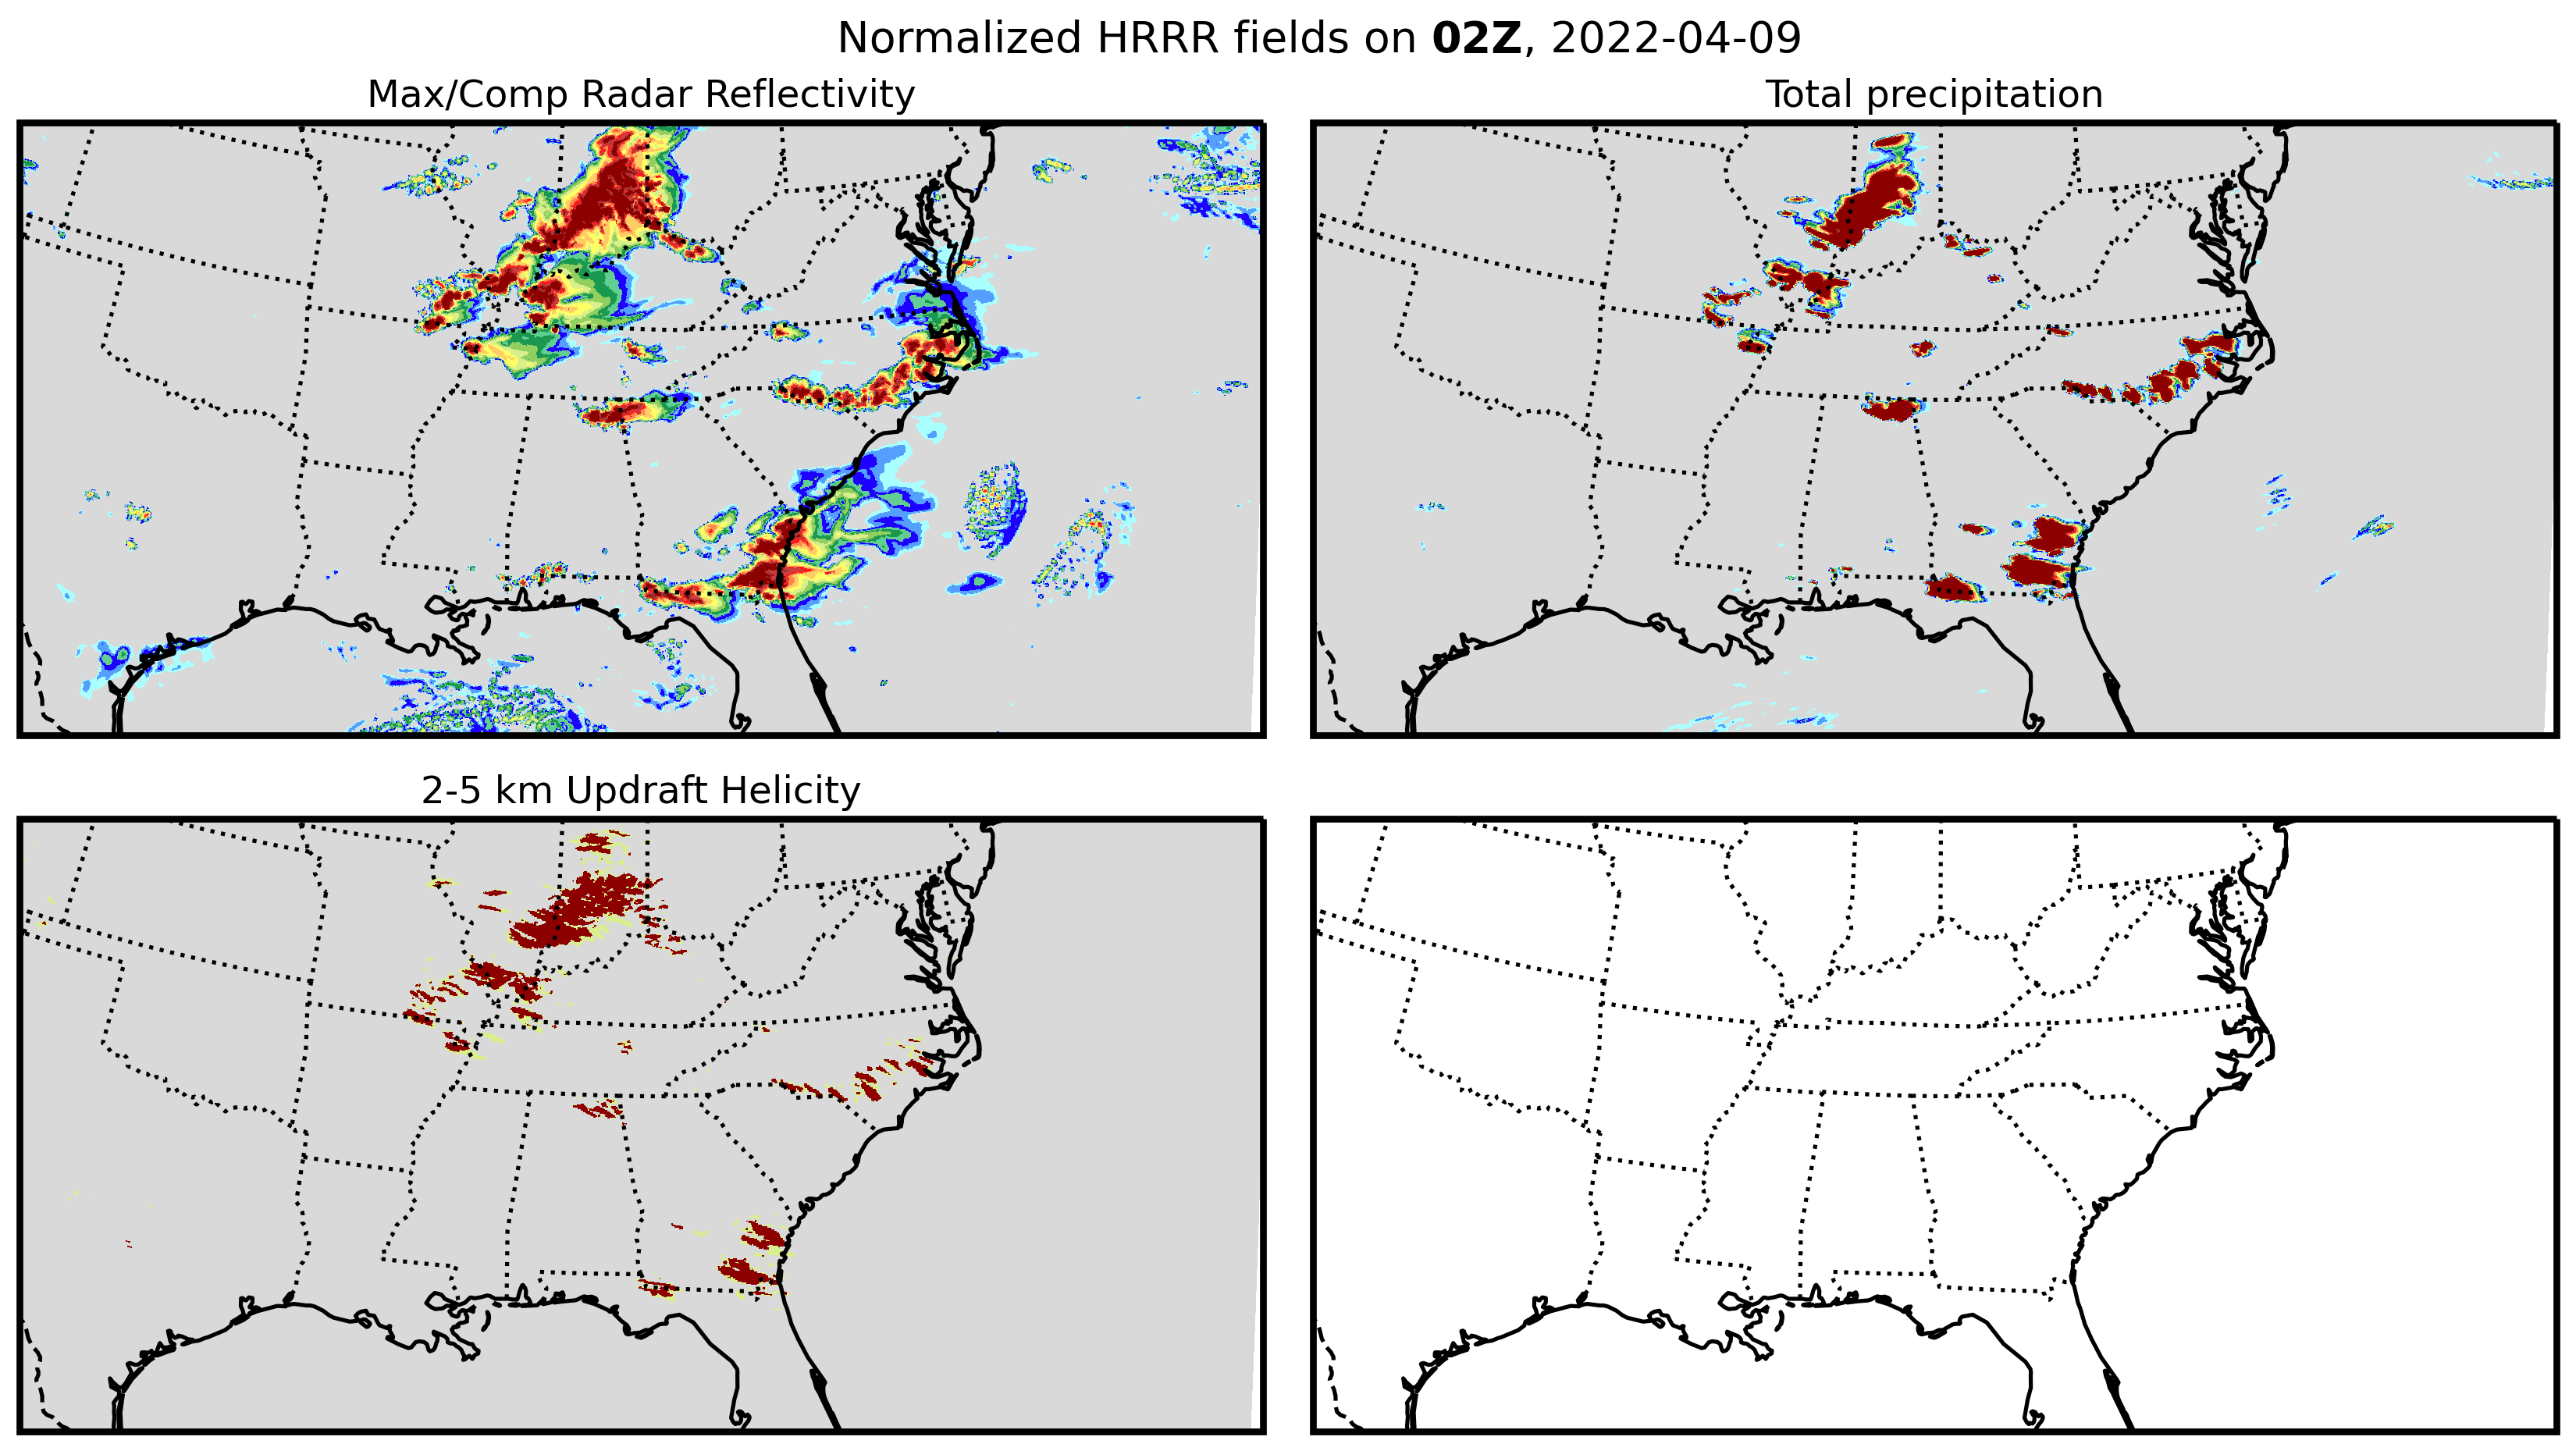

In [21]:
edge = [-100, -70, 27.5, 40]
proj_ = ccrs.NorthPolarStereo(central_longitude=-85)

fig = plt.figure(figsize=(13, 7), dpi=dpi_)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

ax1 = plt.subplot(gs[0, 0], projection=proj_)
ax3 = plt.subplot(gs[0, 1], projection=proj_)
ax2 = plt.subplot(gs[1, 0], projection=proj_)
ax4 = plt.subplot(gs[1, 1], projection=proj_)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.04, wspace=0.04)

AX = [ax1, ax2, ax3, ax4]

for ax in AX:
    #ax = plt.axes(projection=proj_)
    ax.set_extent(edge, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=6)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=6)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=5)
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
    # GL.xlocator = mticker.FixedLocator([-125, -110, -95, -80])
    # GL.ylocator = mticker.FixedLocator([30, 35, 40, 45])
    ax.spines['geo'].set_linewidth(2.5)

ax_t1 = fig.add_axes([0.5-(0.38/2)+0.012, 1.035, 0.38, 0.02])
ax_t1.set_axis_off()
gu.string_partial_format(fig, ax_t1, 0.0, 1.0, 'left', 'top', 
                 ['Normalized HRRR fields on ', '02Z', ', 2022-04-09'],
                 ['k',]*3, [16,]*3, ['normal', 'bold', 'normal']);

ax1.set_title('Max/Comp Radar Reflectivity', fontsize=14)
ax2.set_title('2-5 km Updraft Helicity', fontsize=14)
ax3.set_title('Total precipitation', fontsize=14)

ax1.pcolormesh(lon_3km, lat_3km, data[..., 0], vmin=-10, vmax=40, cmap=cmap_pct, transform=ccrs.PlateCarree())
ax2.pcolormesh(lon_3km, lat_3km, data[..., 3], vmin=0, vmax=2, cmap=cmap_pct, transform=ccrs.PlateCarree())
ax3.pcolormesh(lon_3km, lat_3km, data[..., 14], vmin=0, vmax=2, cmap=cmap_pct, transform=ccrs.PlateCarree())
#ax4.pcolormesh(lon_3km, lat_3km, data[..., 15], vmin=0, vmax=10000, cmap=plt.cm.nipy_spectral_r, transform=ccrs.PlateCarree())

In [64]:
lon_3km

array([[-122.719528  , -122.69286132, -122.6661903 , ...,  -72.3430592 ,
         -72.31638668,  -72.28971849],
       [-122.72702499, -122.70035119, -122.67367305, ...,  -72.33557892,
         -72.30889927,  -72.28222397],
       [-122.73452632, -122.7078454 , -122.68116014, ...,  -72.3280943 ,
         -72.30140753,  -72.2747251 ],
       ...,
       [-134.0648096 , -134.02828423, -133.99174671, ...,  -61.02092594,
         -60.9843842 ,  -60.94785462],
       [-134.08013858, -134.04360126, -134.00705178, ...,  -61.00562502,
         -60.96907132,  -60.93252978],
       [-134.09547973, -134.05893046, -134.02236901, ...,  -60.99031194,
         -60.95374627,  -60.91719277]])

In [59]:
np.max(data[..., 3])

143.0

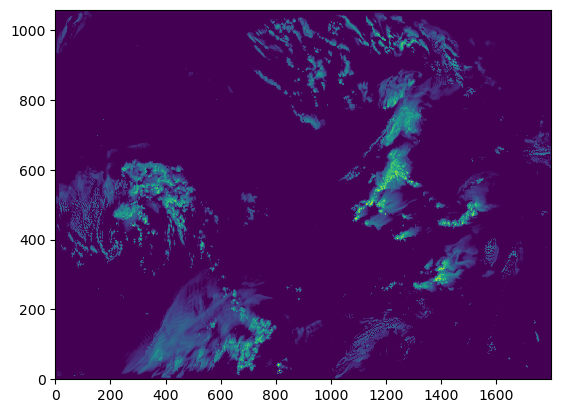

In [20]:
plt.pcolormesh(data[..., 0])

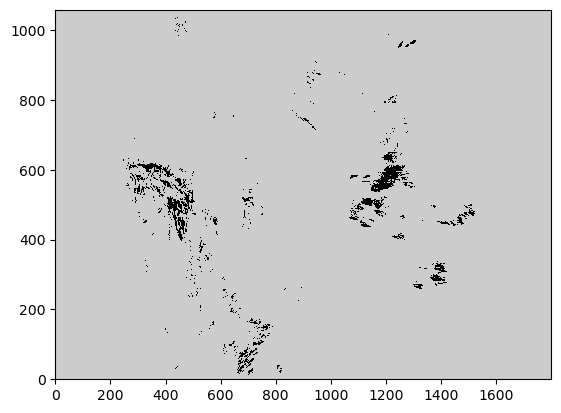

In [66]:
plt.pcolormesh(data[..., 3], vmin=0, vmax=1, cmap=plt.cm.nipy_spectral_r)

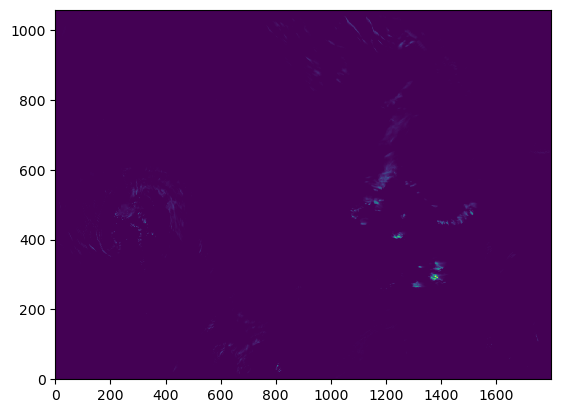

In [23]:
plt.pcolormesh(data[..., 14])

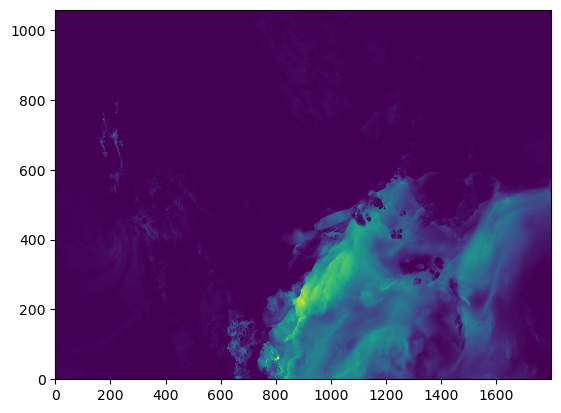

In [24]:
plt.pcolormesh(data[..., 15])